In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import logging
import numpy as np
import py21cmfast as p21c
import math
import time
import imageio
from py21cmfast import (
    AstroParams,
    CosmoParams,
    FlagOptions,
    UserParams,
    determine_halo_list,
    initial_conditions,
    perturb_field,
    plotting
    )

/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:49: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:33: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Load in the recovered binarized boxes from Jonathan. Also included are the wedge-filtered coeval boxes, the original coeval boxes from `21cmFAST` (which can be compared to our own generation of these boxes using identical initial conditions to ensure our analysis is correct), and the set of redshifts at which the boxes are generated. 

In [25]:
from pprint import pprint
import typing
from typing import Optional, List

###############################################################################
#                    DataManager to load data from h5 file                    #
###############################################################################

# Access data like so:
# DM.data["wedge_filtered_brightness_temp_boxes"]
# DM.data["brightness_temp_boxes"]
# DM.data["ionized_boxes"]
# DM.data["redshifts"]
# DM.data["predicted_brightness_temp_boxes"]


class DataManager():

    """
    Loads data from h5py file. Once a DataManager object is loaded, you can
    access the data like so:
         ... = DM.data["wedge_filtered_brightness_temp_boxes"]
         ... = DM.data["brightness_temp_boxes"]
         ... = DM.data["ionized_boxes"]
         ... = DM.data["redshifts"]
         ... = DM.data["predicted_brightness_temp_boxes"]
    Metadata is stored in DM.metadata
    """

    def __init__(self, filepath: str):
        assert filepath[-3:] == ".h5", "filepath must point to an h5 file."

        self.filepath = filepath
        self.metadata = {}
        self.data = {}

        self.load_data_from_h5()
        

    def load_data_from_h5(self):
        """
        Loads coeval boxes from h5py file. Assumes h5py file has 5 datasets,
        'brightness_temp_boxes' -- ground truth brightness temp boxes 
        'wedge_filtered_brightness_temp_boxes' -- brightness temp boxes minus wedge
        'predicted_brightness_temp_boxes' -- predicted brightness temp from model
        'ionized_boxes' -- ionized boxes corresponding to brightness temp box
        'redshifts' --> redshift of each brightness temp box
        """

        with h5py.File(self.filepath, "r") as hf:

            # Check we have the required datasets
            datasets = list(hf.keys())
            assert "wedge_filtered_brightness_temp_boxes" in datasets and \
                   "brightness_temp_boxes" in datasets and \
                   "predicted_brightness_temp_boxes" in datasets and \
                   "ionized_boxes" in datasets and \
                   "redshifts" in datasets, \
                   "Failed to extract datasets from h5py file."

            for k in hf.keys():
                v = np.array(hf[k][:], dtype=np.float32)
                assert np.isnan(np.sum(v)) == False
                self.data[k] = v
            self.data["redshifts"].reshape(-1) 

            # Load metadata from h5 file
            for k, v in hf.attrs.items():
                self.metadata[k] = v

        # Print success message
        print("\n----------\n")
        print(f"data loaded from {self.filepath}")
        print("Contents:")
        for k, v in self.data.items():
            print("\t{}, shape: {}".format(k, v.shape))
        print("\nMetadata:")
        pprint(self.metadata)
        print("\n----------\n")


###############################################################################
#                                   Example                                   #
###############################################################################
def example(DM: DataManager):
    redshifts = DM.data["redshifts"]
    bt_boxes = DM.data["brightness_temp_boxes"]
    predicted_bt_boxes = DM.data["predicted_brightness_temp_boxes"]

    # Binarize the ground truth and lightcones. 
    # Ground truth threshold is ALWAYS 0. 
    binarized_ground_truth = (bt_boxes > 0).astype(np.float32)
    binarized_predictions = (predicted_bt_boxes > 0.5).astype(np.float32)

    true_nfracs = binarized_ground_truth.sum(axis=(1,2,3)) / bt_boxes[0].size
    predicted_nfracs = binarized_predictions.sum(axis=(1,2,3)) / bt_boxes[0].size

    for i, z in enumerate(redshifts):
        print("Redshift: ", z)
        print("\t Ground truth neutral fraction: {}".format(true_nfracs[i]))
        print("\t Predicted neutral fraction: {}\n".format(predicted_nfracs[i]))

if __name__ == "__main__":

    filepath = '/users/jacobkennedy/Desktop/PHYS_459/data/coeval_boxes/z7-8.5_HII-DIM-128_BOX-LEN-128_with_xh_boxes_results.h5'
    DM = DataManager(filepath)

    example(DM)

# We need to transpose all xH_box, brightness_temperature for both predicted and ground truth

gt_ion_box_unT = DM.data['ionized_boxes']
gt_ion_box = np.array([gt_ion_box_unT[i].T for i in range(np.shape(gt_ion_box_unT)[0])])
pred_ion_box_unT = DM.data['predicted_brightness_temp_boxes'] # normalized between 0 and 1, effectively ionized
pred_ion_box = np.array([pred_ion_box_unT[i].T for i in range(np.shape(pred_ion_box_unT)[0])])
redshifts = DM.data['redshifts']


----------

data loaded from /users/jacobkennedy/Desktop/PHYS_459/data/coeval_boxes/z7-8.5_HII-DIM-128_BOX-LEN-128_with_xh_boxes_results.h5
Contents:
	brightness_temp_boxes, shape: (25, 128, 128, 128)
	ionized_boxes, shape: (25, 128, 128, 128)
	predicted_brightness_temp_boxes, shape: (25, 128, 128, 128)
	redshifts, shape: (25,)
	wedge_filtered_brightness_temp_boxes, shape: (25, 128, 128, 128)

Metadata:
{'p21c_initial_conditions': "{'user_params': {'HII_DIM': 128, 'BOX_LEN': 128}, "
                            "'random_seed': 42242}",
 'stats': "{'accuracy': 0.96790314, 'precision': 0.9706921, 'recall': "
          "0.95455635, 'meanIoU': 0.936589, 'nfrac': 0.5678036689758301}"}

----------

Redshift:  7.0
	 Ground truth neutral fraction: 0.349947452545166
	 Predicted neutral fraction: 0.3708958625793457

Redshift:  7.0625
	 Ground truth neutral fraction: 0.37140417098999023
	 Predicted neutral fraction: 0.38408946990966797

Redshift:  7.125
	 Ground truth neutral fraction: 0.39264154

In [56]:
# Useful Functions

def binarize_boxes(boxes, cutoff=0.9): # binarize ionized boxes, neutral maps to 1, ionized to 0
    num_box = boxes.shape[0]
    for i in range(num_box):
        sup_threshold_inds = (boxes[i] >= cutoff) # map to 1
        sub_threshold_inds = (boxes[i] < cutoff) # map to 0
        boxes[i][sup_threshold_inds] = 1 
        boxes[i][sub_threshold_inds] = 0
    return boxes

def load_halo_from_h5(halo_file,redshifts):  # function to read in masses, coords, ionized boxes
    
    num_z = len(redshifts)
    halo_coord_z = []
    halo_mass_z = []

    with h5py.File(halo_file, "r") as hf1:
        print("Datasets: ", list(hf1.keys()))
        for i in range(num_z):
            temp_halo_mass_name = 'halo_masses_'+repr(redshifts[i])
            temp_halo_coord_name = 'halo_coords_'+repr(redshifts[i])
            print(temp_halo_mass_name)
            print(temp_halo_coord_name)
            temp_halo_masses = hf1[temp_halo_mass_name][:]
            temp_halo_coords = hf1[temp_halo_coord_name][:]
            halo_coord_z.append(temp_halo_coords)
            halo_mass_z.append(temp_halo_masses)
        hf1.close()

    return np.array(halo_coord_z), np.array(halo_mass_z)

def get_halo_coords_masses(redshifts, init_cond, fname): # Perturb to desired redshift and get halo coords, masses
    num_z = len(redshifts)
    halo_coords_z = []
    halo_masses_z = []
    
    print('======= starting file writing ========')
    hf_halos_z = h5py.File('/users/jacobkennedy/Desktop/PHYS_459/data/coeval_boxes/'+fname+'.h5', 'w')
    print('======== file opened, writing now ======')
    
    for i in range(num_z):
        start = time.time()
        halos = determine_halo_list(
            redshift=redshifts[i],
            init_boxes=init_cond,
            regenerate=True,
            write=False,
            OPTIMIZE=False,
            )
        end = time.time()
        print('Redshift: '+repr(redshifts[i]) +' got halo list in ' + repr(end-start) + ' sec')

        list_halo_coords = halos.halo_coords
        halo_coords_z.append(list_halo_coords)
        list_halo_masses = halos.halo_masses
        halo_masses_z.append(list_halo_masses)
        hf_halos_z.create_dataset('halo_masses_'+repr(redshifts[i]), data=list_halo_masses)
        hf_halos_z.create_dataset('halo_coords_'+repr(redshifts[i]), data=list_halo_coords)

    hf_halos_z.close()

    halo_coords_z = np.array(halo_coords_z)
    halo_masses_z = np.array(halo_masses_z)
    
    return halo_coords_z

def plot_histogram_lumo(halo_L, name, save=False, ax=None, fig=None, label='', colour='red', bins=None,lims=None):
    if (ax is None) and (fig is None):
        fig,ax = plt.subplots(figsize=(14,8))
        colour='blue'
    log_halo_L = np.log10(halo_L)
    if bins == None:
        bins=len(np.unique(log_halo_L))
    ax.hist(log_halo_L,bins=bins, lw=1, ec='black', fc=colour, alpha=0.5, label=label,range=lims) # normalize histogram
    ax.set_yscale('log')
    ax.set_xlabel('$log(L_{halo} / L_{Sun})$', fontsize = 30)
    ax.set_title('Halo Luminosity Distribution Over '+name, fontsize = 30)
    ax.set_ylabel('Halo Counts', fontsize = 30);
    ax.tick_params(axis='x',labelsize=30)
    ax.tick_params(axis='y',labelsize=30)
    ax.legend(fontsize=16)
    if save:
        splitname = name.split()
        savename = "_".join(splitname)
        fig.savefig('halo_L_dist_'+savename+'.jpg')
    return fig, ax

# function to plot log of halo masses

def plot_histogram(halomasses, name, save=False, ax=None, fig=None, label='', colour='red', bins=None,lims=None, xlabel=True, ylabel=True, weights=None):
    if (ax is None) and (fig is None):
        fig,ax = plt.subplots(figsize=(14,8))
        colour='blue'
    log_halomasses = np.log10(halomasses)
    if bins is None:
        bins=len(np.unique(log_halomasses))
    ax.hist(log_halomasses,bins=bins, lw=1, ec='black', fc=colour, alpha=0.5, label=label,range=lims, weights=weights, density=True) # normalize histogram
    ax.set_yscale('log')
    if xlabel:
        ax.set_xlabel('$log(M_{h} / M_{\odot})$', fontsize = 30)
    ax.set_title(name, fontsize = 30) #'Halo Mass Distribution Over '+name, fontsize = 20)
    if ylabel:
        ax.set_ylabel('Normed Halo Counts', fontsize = 30);
    ax.tick_params(axis='x',labelsize=20)
    ax.tick_params(axis='y',labelsize=20)
    #ax.legend(fontsize=16)
    if save:
        splitname = name.split()
        savename = "_".join(splitname)
        fig1.savefig('halo_mass_distr_'+savename)
    return fig, ax

def get_n_i_mass_coords(halocoords, halomasses, ionizedbox, n_frac_threshold=0.9):
    '''
    Given we want to examine what halo masses are found in the recovered boxes, 
    we need to write a function to find the halo coordinates and masses corresponding 
    to those halos found in the ionized bubbles (and neutral areas as well).
    ------------------------------------------------------------------------------
    halocoords: 
            Coordinates of halos in box.
    halomasses:
            Masses of halos in box
    ionizedbox: 
            3-D box of HII_DIM sidelength, with entries indicating neutral fraction of voxel. 
    n_frac_threshold:
            Neutral fraction threshold, default is 0.9.
    ------------------------------------------------------------------------------
    ''' 
    halo_low_res_coords = halocoords // 3 # need to scale down dimension from high to low resolution
    
    neutral_halo_coords = []
    neutral_halo_masses = []
    ionized_halo_coords = []
    ionized_halo_masses = []
    
    for i in range(len(halo_low_res_coords)): 
        z = halo_low_res_coords[i][0]
        y = halo_low_res_coords[i][1]
        x = halo_low_res_coords[i][2]
        
        if ionizedbox[z,y,x] >=n_frac_threshold: # check if neutral fraction greater than threshold
            neutral_halo_coords.append(np.array([z,y,x]))
            neutral_halo_masses += [halomasses[i]]
            
        else:
            ionized_halo_coords.append(np.array([z,y,x]))
            ionized_halo_masses += [halomasses[i]]

    
    #return [neutral_halo_coords, neutral_halo_masses, ionized_halo_coords, ionized_halo_masses]
    return np.array(neutral_halo_coords),np.array(neutral_halo_masses), np.array(ionized_halo_coords), np.array(ionized_halo_masses)

def sort_masses(halomasses, halocoords):
    '''
    If we wish to get a sorted list of halo masses and halo coordinates (in the same order), 
    this can be done using the following function.
    '''
    sorted_halomasses_inds = np.argsort(halomasses)
    sorted_halomasses = halomasses[sorted_halomasses_inds]
    sorted_halocoords = halocoords[sorted_halomasses_inds]
    return [sorted_halomasses,sorted_halocoords]

def load_halo_ion_from_h5(ion_box_file,halo_file,redshifts): 
    '''
    Function to read in masses, coords, ionized boxes from .h5.
    '''
    num_z = len(redshifts)
    ion_boxes_z = np.zeros((num_z,128,128,128))
    halo_coord_z = []
    halo_mass_z = []
    
    with h5py.File(ion_box_file, "r") as hf:
        #print("Datasets: ", list(hf.keys()))
        for i in range(num_z):
            ion_box_z_name = 'ionized_box_'+repr(redshifts[i])
            #print(ion_box_z_name)
            ion_boxes_z[i] = hf[ion_box_z_name][:]
        hf.close()
    
    with h5py.File(halo_file, "r") as hf1:
        #print("Datasets: ", list(hf1.keys()))
        for i in range(num_z):
            temp_halo_mass_name = 'halo_masses_'+repr(redshifts[i])
            temp_halo_coord_name = 'halo_coords_'+repr(redshifts[i])
            #print(temp_halo_mass_name)
            #print(temp_halo_coord_name)
            temp_halo_masses = hf1[temp_halo_mass_name][:]
            temp_halo_coords = hf1[temp_halo_coord_name][:]
            halo_coord_z.append(temp_halo_coords)
            halo_mass_z.append(temp_halo_masses)
        hf1.close()

    return ion_boxes_z, np.array(halo_coord_z), np.array(halo_mass_z)

def plot_slice(box,n_xyz=(0,None,None),fig=None,ax=None):
    if (ax is None) and (fig is None):
        fig,ax = plt.subplots(figsize=[8,8])
    if isinstance(n_xyz[0], int):
        ax.imshow(box[n_xyz[0],:,:], cmap='Greys', origin='lower')
        ax.set_ylabel('z-axis [Mpc]', fontsize=30)
        ax.set_xlabel('x-axis [Mpc]', fontsize=30)
    elif isinstance(n_xyz[1], int):
        ax.imshow(box[:,n_xyz[1],:], cmap='Greys', origin='lower')
        ax.set_ylabel('z-axis [Mpc]', fontsize=30)
        ax.set_xlabel('x-axis [Mpc]', fontsize=30)
    else:
        ax.imshow(box[:,:,n_xyz[2]], cmap='Greys', origin='lower')
        ax.set_ylabel('y-axis [Mpc]', fontsize=30)
        ax.set_xlabel('x-axis [Mpc]', fontsize=30)
    ax.tick_params(axis='both',labelsize=15);
    return fig, ax

def MI_map(gt_map, pred_map):
    return np.multiply(gt_map, pred_map)

In [27]:
binarized_gt_ion_box = binarize_boxes(gt_ion_box)
binarized_pred_ion_box = binarize_boxes(pred_ion_box)
halo_coords_z, halo_masses_z = load_halo_from_h5('/users/jacobkennedy/Desktop/PHYS_459/data/coeval_boxes/halo_masses_coords_7.0-8.5.h5', redshifts)

Datasets:  ['halo_coords_7.0', 'halo_coords_7.0625', 'halo_coords_7.125', 'halo_coords_7.1875', 'halo_coords_7.25', 'halo_coords_7.3125', 'halo_coords_7.375', 'halo_coords_7.4375', 'halo_coords_7.5', 'halo_coords_7.5625', 'halo_coords_7.625', 'halo_coords_7.6875', 'halo_coords_7.75', 'halo_coords_7.8125', 'halo_coords_7.875', 'halo_coords_7.9375', 'halo_coords_8.0', 'halo_coords_8.0625', 'halo_coords_8.125', 'halo_coords_8.1875', 'halo_coords_8.25', 'halo_coords_8.3125', 'halo_coords_8.375', 'halo_coords_8.4375', 'halo_coords_8.5', 'halo_masses_7.0', 'halo_masses_7.0625', 'halo_masses_7.125', 'halo_masses_7.1875', 'halo_masses_7.25', 'halo_masses_7.3125', 'halo_masses_7.375', 'halo_masses_7.4375', 'halo_masses_7.5', 'halo_masses_7.5625', 'halo_masses_7.625', 'halo_masses_7.6875', 'halo_masses_7.75', 'halo_masses_7.8125', 'halo_masses_7.875', 'halo_masses_7.9375', 'halo_masses_8.0', 'halo_masses_8.0625', 'halo_masses_8.125', 'halo_masses_8.1875', 'halo_masses_8.25', 'halo_masses_8.3125'

/var/folders/xs/9jq8mv4s1clbtpmn6f0vrgsc0000gp/T/ipykernel_26182/2155901887.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(halo_coord_z), np.array(halo_mass_z)


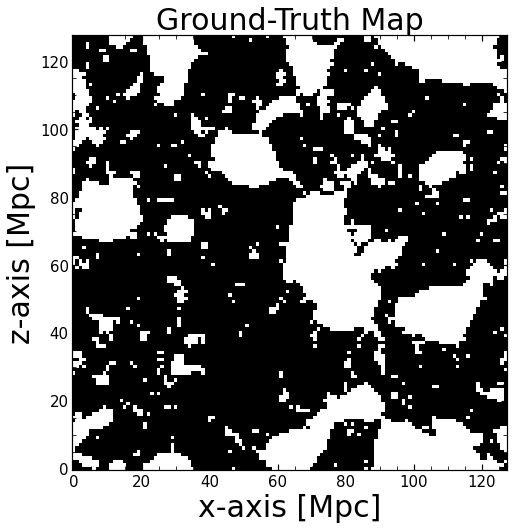

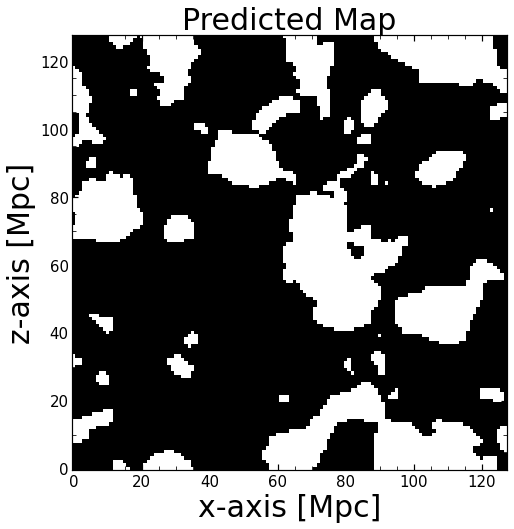

In [31]:
fig_gt,ax_gt=plot_slice(binarized_gt_ion_box[-9])
fig_pred,ax_pred=plot_slice(binarized_pred_ion_box[-9])
ax_gt.set_title('Ground-Truth Map', fontsize=30)
ax_pred.set_title('Predicted Map', fontsize=30);

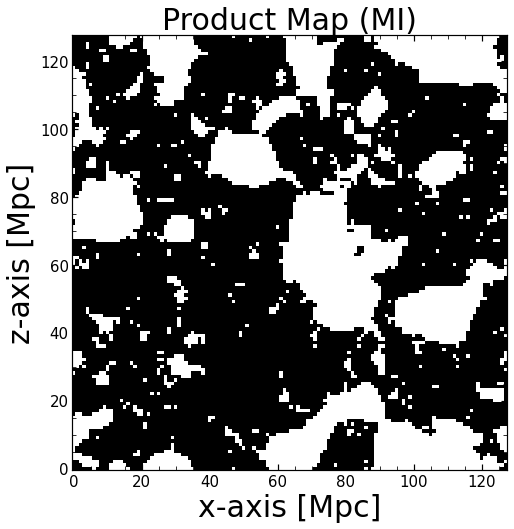

In [30]:
# Multiply to get MI map
MI_map_z8 = MI_map(binarized_gt_ion_box[-9],binarized_pred_ion_box[-9])
fig_MI,ax_MI=plot_slice(MI_map_z8)
halo_coords_z8 = halo_coords_z[-9]
halo_masses_z8 = halo_masses_z[-9]
ax_MI.set_title('Product Map (MI)',fontsize=30);

In [33]:
# Now look at difference of MI map with gt and pred maps

MI_n_halo_coords_z8, MI_n_halo_masses_z8, MI_i_halo_coords_z8, MI_i_halo_masses_z8 = get_n_i_mass_coords(
                                                                halo_coords_z8, halo_masses_z8, MI_map_z8)  
n_gt_halo_coords_z8, n_gt_halo_masses_z8, i_gt_halo_coords_z8, i_gt_halo_masses_z8 = get_n_i_mass_coords(
                                                        halo_coords_z8, halo_masses_z8, binarized_gt_ion_box[-9])
n_pred_halo_coords_z8, n_pred_halo_masses_z8, i_pred_halo_coords_z8, i_pred_halo_masses_z8 = get_n_i_mass_coords(
                                                        halo_coords_z8, halo_masses_z8, binarized_pred_ion_box[-9])

MI_i_unique_mass_z8, MI_i_unique_counts_z8 = np.unique(MI_i_halo_masses_z8, return_counts=True)
i_gt_unique_mass_z8, i_gt_unique_counts_z8 = np.unique(i_gt_halo_masses_z8, return_counts=True)
i_pred_unique_mass_z8, i_pred_unique_counts_z8 = np.unique(i_pred_halo_masses_z8, return_counts=True)
MI_n_unique_mass_z8, MI_n_unique_counts_z8 = np.unique(MI_n_halo_masses_z8, return_counts=True)
n_gt_unique_mass_z8, n_gt_unique_counts_z8 = np.unique(n_gt_halo_masses_z8, return_counts=True)
n_pred_unique_mass_z8, n_pred_unique_counts_z8 = np.unique(n_pred_halo_masses_z8, return_counts=True)

MI_diff_gt_i_masses = MI_i_unique_counts_z8 - i_gt_unique_counts_z8
MI_diff_gt_n_masses = MI_n_unique_counts_z8 - n_gt_unique_counts_z8
MI_diff_pred_i_masses = MI_i_unique_counts_z8 - i_pred_unique_counts_z8
MI_diff_pred_n_masses = MI_n_unique_counts_z8 - n_pred_unique_counts_z8

In [54]:
print(MI_diff_gt_n_masses)
print(MI_diff_pred_n_masses)

[  -783   -919   -980  -1073 -51653   -135   -115   -113  -2719    -53
   -442   -345   -319   -125    -10    -92   -129    -67    -20    -62
    -22    -25    -10     -9     -8     -4     -3     -1     -1    -99]
[  -2224   -2644   -2891   -3241 -187635    -382    -399    -371   -9297
    -130   -1409   -1062   -1054    -423     -37    -273    -411    -218
    -101    -180     -85    -105     -84     -79     -81     -60     -45
     -33      -9    -346]


(<Figure size 1008x576 with 1 Axes>,
 <AxesSubplot:title={'center':'MI-PI'}, xlabel='$log(M_{h} / M_{\\odot})$', ylabel='Normed Halo Counts'>)

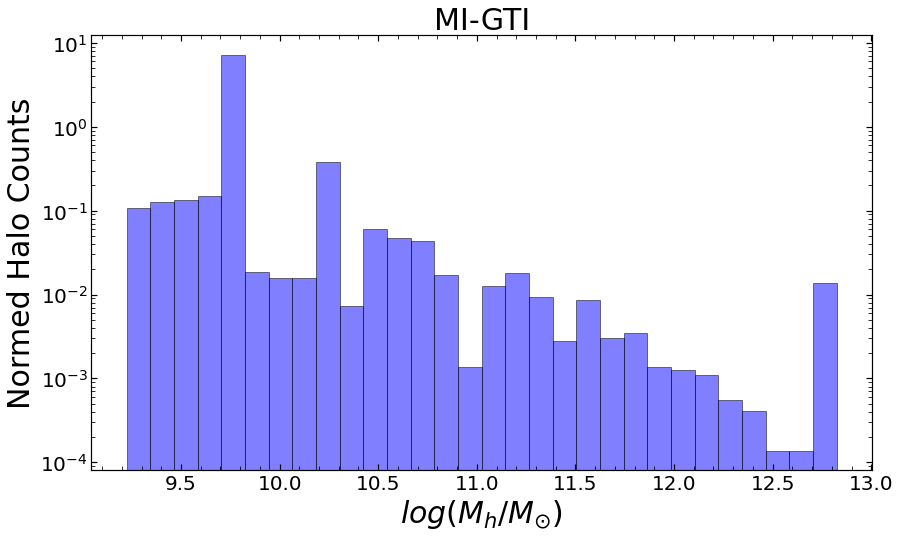

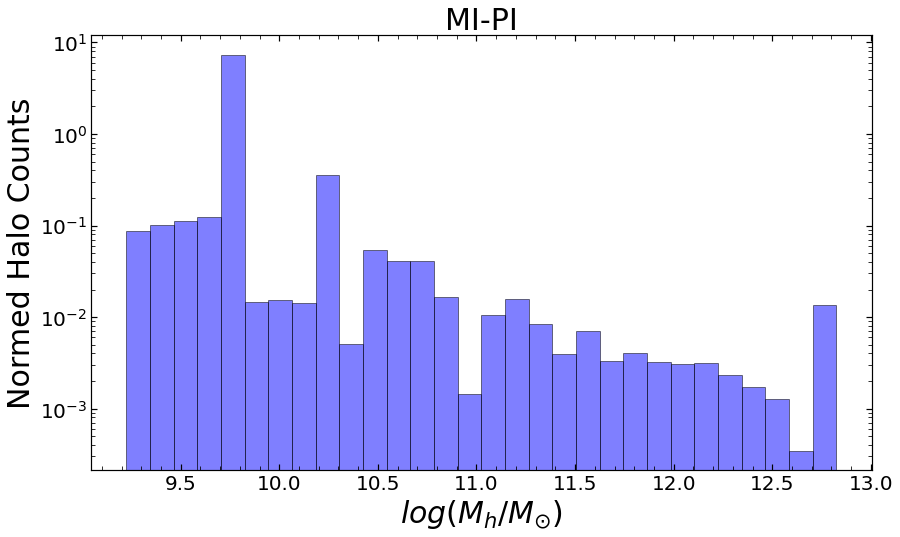

In [57]:
plot_histogram(MI_i_unique_mass_z8, 'MI-GTI', save=False, ax=None, fig=None, label='', colour='red', bins=len(MI_diff_gt_i_masses),lims=None, xlabel=True, ylabel=True, weights=MI_diff_gt_i_masses)
plot_histogram(MI_i_unique_mass_z8, 'MI-PI', save=False, ax=None, fig=None, label='', colour='red', bins=len(MI_diff_pred_i_masses),lims=None, xlabel=True, ylabel=True, weights=MI_diff_pred_i_masses)
#plot_histogram(MI_i_unique_mass_z8, 'MIN-GTN', save=False, ax=None, fig=None, label='', colour='red', bins=len(MI_diff_gt_n_masses),lims=None, xlabel=True, ylabel=True, weights=MI_diff_gt_n_masses)
#plot_histogram(MI_i_unique_mass_z8, 'MIN-PN', save=False, ax=None, fig=None, label='', colour='red', bins=len(MI_diff_pred_n_masses),lims=None, xlabel=True, ylabel=True, weights=MI_diff_pred_n_masses)

Now initialize an identical coeval box using `21cmFAST` with the same initial conditions, which will carry all the additional information on halo positions and sizes which we can use to analyze the recovered boxes.

In [15]:
# get ionized and neutral masses/coords for z=8 -----> -9 index

all_n_rec_halo_coords=[]
all_n_rec_halo_masses=[]
all_i_rec_halo_coords=[]
all_i_rec_halo_masses=[]
all_n_gt_halo_coords=[]
all_n_gt_halo_masses=[]
all_i_gt_halo_coords=[]
all_i_gt_halo_masses=[]

# recovered box
rec_ionized_box = binarized_pred_ion_box_z8
start=time.time()
n_rec_halo_coords, n_rec_halo_masses, i_rec_halo_coords, i_rec_halo_masses = get_n_i_mass_coords(halo_coords_z[-9], halo_masses_z[-9], rec_ionized_box)    
all_n_rec_halo_coords.append(n_rec_halo_coords)
all_n_rec_halo_masses.append(n_rec_halo_masses)
all_i_rec_halo_coords.append(i_rec_halo_coords)
all_i_rec_halo_masses.append(i_rec_halo_masses)
end=time.time()
print('Recovered box retrieval took: ', end-start)
# ground truth box
start=time.time()
gt_ionized_box = binarized_gt_ion_box_z8
n_gt_halo_coords, n_gt_halo_masses, i_gt_halo_coords, i_gt_halo_masses = get_n_i_mass_coords(halo_coords_z[-9], halo_masses_z[-9], gt_ionized_box)  
all_n_gt_halo_coords.append(n_gt_halo_coords)
all_n_gt_halo_masses.append(n_gt_halo_masses)
all_i_gt_halo_coords.append(i_gt_halo_coords)
all_i_gt_halo_masses.append(i_gt_halo_masses)
end=time.time()
print('Ground truth box retrieval took: ', end-start)

Recovered box retrieval took:  23.685840129852295
Ground truth box retrieval took:  26.646294116973877


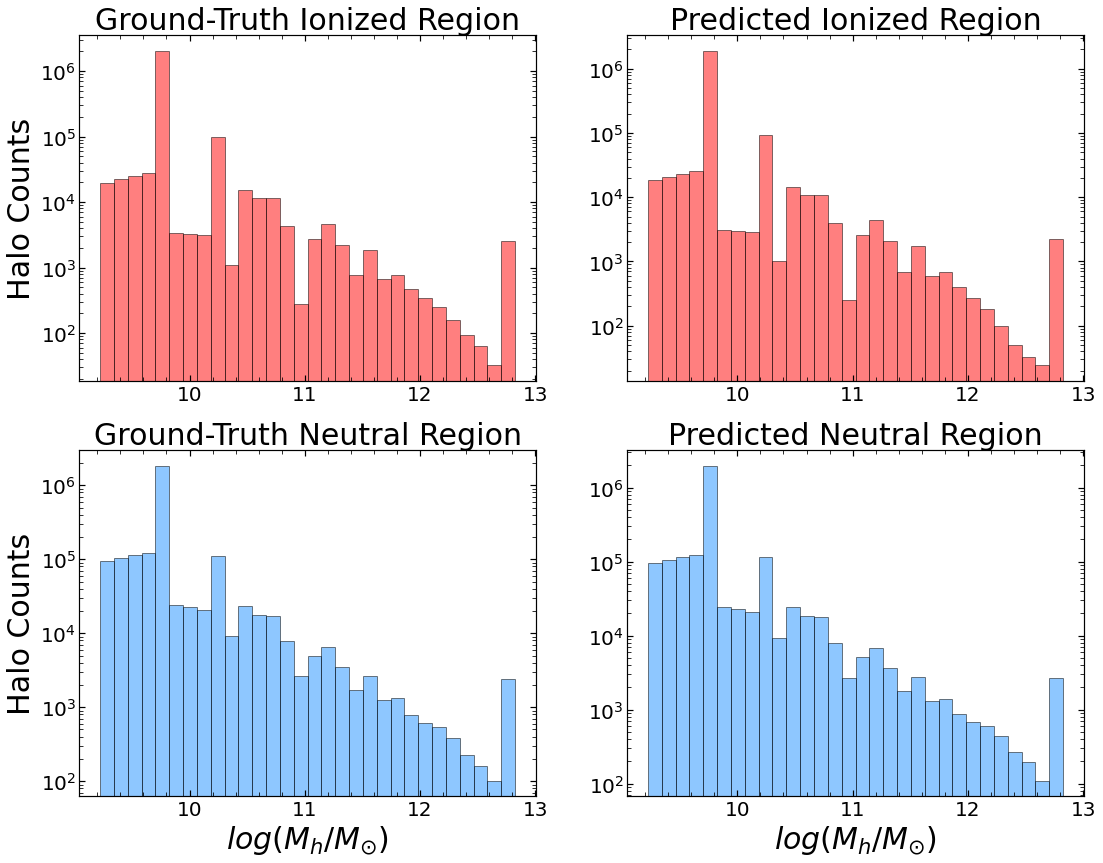

In [19]:
fig25, ax25 = plt.subplots(nrows=2, ncols=2, figsize=[18,14])
plot_histogram(all_i_gt_halo_masses[0], 'Ground-Truth Ionized Region', fig=fig25, ax=ax25[0,0], colour='red', xlabel=False)
plot_histogram(all_n_gt_halo_masses[0], 'Ground-Truth Neutral Region', fig=fig25, ax=ax25[1,0], colour='dodgerblue')
plot_histogram(all_i_rec_halo_masses[0], 'Predicted Ionized Region', fig=fig25, ax=ax25[0,1], colour='red', xlabel=False, ylabel=False)
plot_histogram(all_n_rec_halo_masses[0], 'Predicted Neutral Region', fig=fig25, ax=ax25[1,1], colour='dodgerblue', ylabel=False);
#fig25.savefig('/users/jacobkennedy/Desktop/PHYS_459/report_figures/halo_mass_distr_comp.jpeg')

In [21]:
# Make plot for Jordan

# Load in the mass luminosity relation data

i_gt_halo_masses_z8 = all_i_gt_halo_masses[0]
i_pred_halo_masses_z8 = all_i_rec_halo_masses[0]
n_gt_halo_masses_z8 = all_n_gt_halo_masses[0]
n_pred_halo_masses_z8 = all_n_rec_halo_masses[0]

dat = np.loadtxt('/users/jacobkennedy/Desktop/PHYS_459/data/Mh_ML_relations/L1600_vs_Mh_and_z.dat').T
Mh, L_1600_z6, L_1600_z7, L_1600_z8, L_1600_z9, L_1600_z10 = dat

# Given list of halo masses, would need to interpolate using np.interp
#halo_lumo_z7 = np.interp((halo_masses_z7), xp = Mh, fp = L_1600_z7)
i_gt_halo_lumo_z8 = np.interp((i_gt_halo_masses_z8), xp = Mh, fp = L_1600_z8)
i_pred_halo_lumo_z8 = np.interp((i_pred_halo_masses_z8), xp = Mh, fp = L_1600_z8)
n_gt_halo_lumo_z8 = np.interp((n_gt_halo_masses_z8), xp = Mh, fp = L_1600_z8)
n_pred_halo_lumo_z8 = np.interp((n_pred_halo_masses_z8), xp = Mh, fp = L_1600_z8)

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
cm_per_pc = 3.08568e18
flux_AB = 3631. * 1e-23 # erg / s / cm**2 / Hz

def L_to_MAB(L): # given L returns absolute magnitude M_AB
        d10 = 10 * cm_per_pc # 10pc in cm
        return -2.5 * np.log10(L / 4. / np.pi / d10**2 / flux_AB)

def get_mag_app(z, mags):
    """
    Convert absolute magnitudes to apparent magnitudes. Should put this in ARES.
    """
    d_pc = 1e6*cosmo.luminosity_distance(z) / u.Mpc
    return mags + 5 * np.log10(d_pc / 10.) - 2.5 * np.log10(1. + z)

Text(0.5, 1.0, '$m_{AB}$ vs $M_{h}$ for PI Regions')

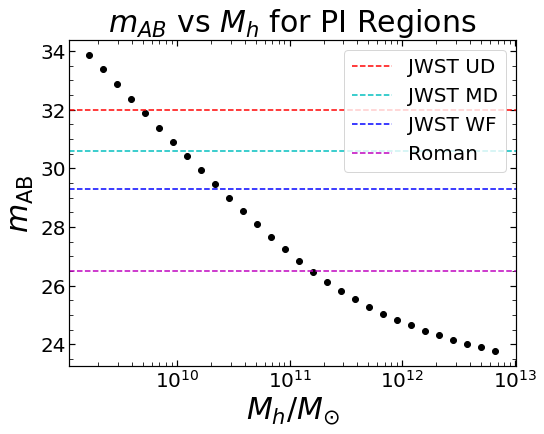

In [22]:
z=8

M_AB = L_to_MAB(i_pred_halo_lumo_z8)
m_AB = get_mag_app(z, M_AB)

fig, ax = plt.subplots(1, 1, figsize=[8,6])

# Plot Mh v. apparent mags for PI region halos
unique_Mh, Mh_counts = np.unique(i_pred_halo_masses_z8, return_counts=True)
unique_m_AB, m_AB_counts = np.unique(m_AB, return_counts=True)
ax.scatter(unique_Mh, unique_m_AB[::-1], color='k') 
# need to flip absolute magnitudes because sorting of np.unique

# Plot mag limits for various upcoming surveys. Check out Table 2 in Mason
# et al. (2015) for details.

ax.axhline(32, color='r', ls='--', label='JWST UD')
ax.axhline(30.6, color='c', ls='--', label='JWST MD')
ax.axhline(29.3, color='b', ls='--', label='JWST WF')
ax.axhline(26.5, color='m', ls='--', label='Roman')

# Clean it up.
ax.set_xscale('log')
ax.set_xlabel(r'$M_h / M_{\odot}$', fontsize=30)
ax.set_ylabel(r'$m_{\rm{AB}}$', fontsize=30)
ax.tick_params(axis='both',labelsize=20)
ax.legend(fontsize=20, loc='upper right')
ax.set_title('$m_{AB}$ vs $M_{h}$ for PI Regions', fontsize=30)
#fig.savefig('/users/jacobkennedy/Desktop/PHYS_459/report_figures/m_AB_vs_Mh_mlim.jpeg');

In [23]:
print(Mh_counts,'\n',  m_AB_counts[::-1])

[  18453   20918   23179   25993 1891418    3069    2940    2885   92650
    1001   14372   10712   10833    3970     248    2568    4414    2098
     682    1714     603     697     396     272     180     100      50
      32      24    2263] 
 [  18453   20918   23179   25993 1891418    3069    2940    2885   92650
    1001   14372   10712   10833    3970     248    2568    4414    2098
     682    1714     603     697     396     272     180     100      50
      32      24    2263]


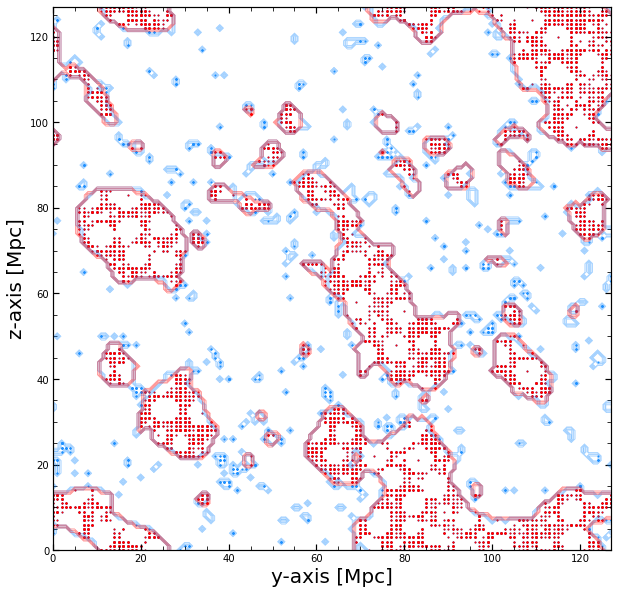

In [58]:
x = np.arange(0,128)
y = np.arange(0,128)
X,Y = np.meshgrid(x,y)
n_x = 10
for i in range(1):
    i_rec_halo_slice_coords = all_i_rec_halo_coords[0][all_i_rec_halo_coords[0][:,0]==n_x]
    i_gt_halo_slice_coords = all_i_gt_halo_coords[0][all_i_gt_halo_coords[0][:,0]==n_x]
    gt_slice = binarized_gt_ion_box_z8[10,:,:]
    pred_slice = binarized_pred_ion_box_z8[10,:,:]
    fig10,ax10 = plt.subplots(figsize=[10,10])
    ax10.scatter(x=i_gt_halo_slice_coords[:,2], y=i_gt_halo_slice_coords[:,1], 
                marker='.', s=4.0, c='dodgerblue')
    ax10.scatter(x=i_rec_halo_slice_coords[:,2], y=i_rec_halo_slice_coords[:,1], 
                marker='.', s=4.0,  c='red')
    ax10.contour(X,Y,gt_slice, colors='dodgerblue', linewidths=0.2)
    ax10.contour(X,Y,pred_slice, colors='red', linewidths=0.2)
    ax10.set_ylabel('z-axis [Mpc]', fontsize=20)
    ax10.set_xlabel('y-axis [Mpc]', fontsize=20)
    #plt.show();
    #plt.close(fig10)
    #fig.savefig('new_contours_z8.jpg')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(<Figure size 1008x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Halo Luminosity Distribution Over PI at z=8'}, xlabel='$log(L_{halo} / L_{Sun})$', ylabel='Halo Counts'>)

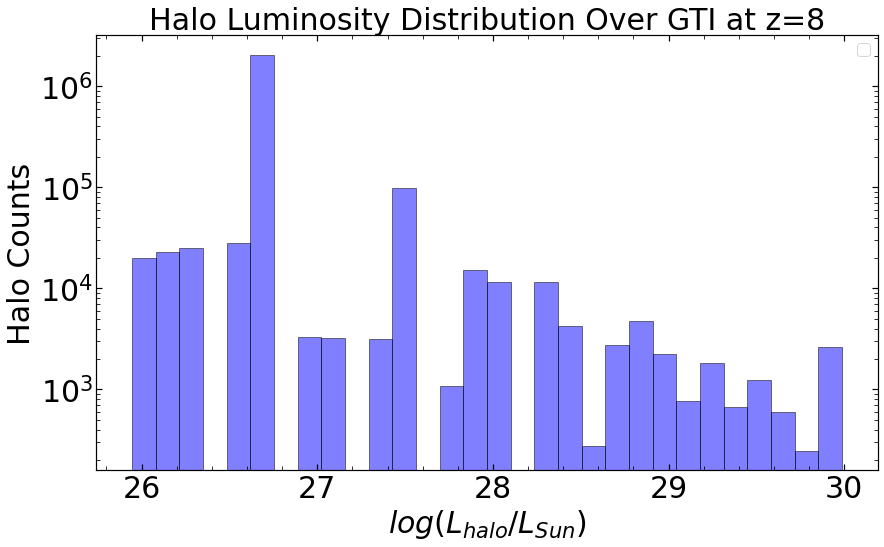

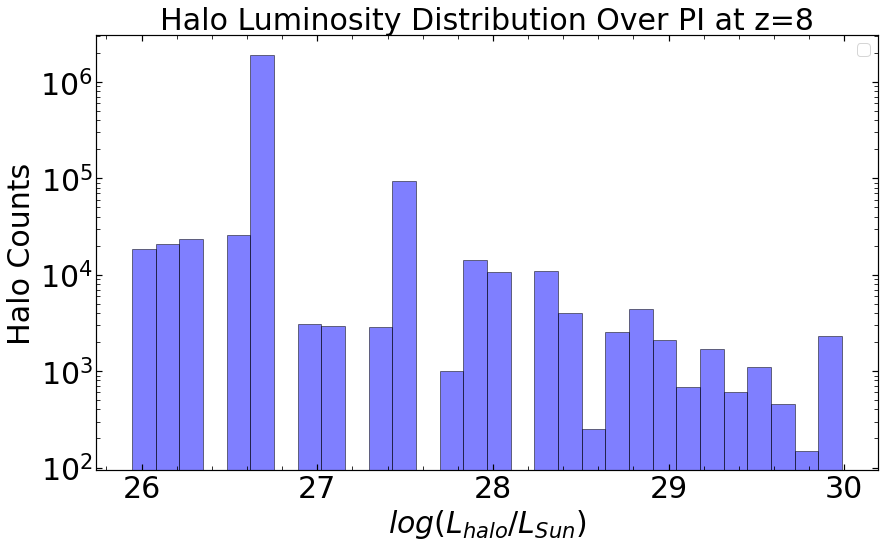

In [42]:
plot_histogram_lumo(i_gt_halo_lumo_z8, 'GTI at z=8')#,save=True)
plot_histogram_lumo(i_pred_halo_lumo_z8, 'PI at z=8') #, save=True)

Now we can examine what types of halo masses `21cmFAST` generates. This is done using the list of halo-type objects `halos`, which we have already obtained above. These objects contain attributes pertaining to the halo mass and coordinates in the box. Looking at the distribution of halo masses (via a histogram) is useful to understand the range and frequency of halo masses in the box.

In [21]:
# Plot histogram of halo masses from whole cube
if 0:
    halo_masses_cube = halos.halo_masses
    hist_fig, hist_ax = plot_histogram(halo_masses_cube,'Whole Box',save=False,label='All Regions')

To access the halos in a particular slice, we can specify the particular index we want to keep. As mentioned above, the coordinates of the box take the form $(z,y,x)$. This is done below for an $x$-axis slice with index $x=0$. The corresponding halo mass histogram is displayed below as well, and has a similar general shape to that which includes the halo masses from the whole box.

In [22]:
if 0:
    halo_masses_slice = halos.halo_masses[halos.halo_coords[:,2]==0]

    hist_slice_fig, hist_slice_ax = plot_histogram(halo_masses_slice, 'x=0 Slice', save=False)

In [ ]:
ion_file = 'ionized_boxes_8.5-10.h5'
halos_file = 'halo_masses_coords_8.5-10.h5'

ionized_boxes_z, halo_coords_z, halo_masses_z = load_halo_ion_from_h5(ion_file,halos_file,redshifts)

In [ ]:
binarized_gt_boxes_z = binarize_boxes(ionized_boxes_z) # binarize the boxes for plotting, etc

In [ ]:
if 0:
    for i in range(num_z):
        fig3, ax3 = plt.subplots(ncols=2,figsize=[14, 8])
        n_x=50
        #halo_slice_coords = i_rec_halo_coords[i_rec_halo_coords[:,0]==n_x]
        ax3[0].imshow(binarized_gt_boxes[i][n_x,:,:], cmap='Greys', origin='lower') # take x = 0 slice
        print('GT Slice Neutral Fraction: ', binarized_gt_boxes[i][n_x,:,:].mean())
        ax3[1].imshow(Y[i][n_x,:,:], cmap='Greys', origin='lower') # take x = 0 slice
        print('Pred Slice Neutral Fraction: ', binarized_pred_boxes[i][n_x,:,:].mean())
        #im = ax3.scatter(x=halo_coords_z[:,1, y=nslice_halo_coords[:,0], 
        #            marker='*', s=5.0, label = 'Neutral Region Halos', c='r')
        #im2 = ax3.scatter(x=islice_halo_coords[:,1], y=islice_halo_coords[:,0], 
        #            marker='*', s=5.0, label = 'Ionized Region Halos', c='blue')
        ax3[0].set_xlim(0, 127)
        ax3[0].set_ylim(0, 127)
        ax3[1].set_xlim(0, 127)
        ax3[1].set_ylim(0, 127)
        #ax3.legend(fontsize=14, loc='right')
        ax3[0].set_ylabel('z-axis [Mpc]', fontsize=20)
        ax3[0].set_xlabel('y-axis [Mpc]', fontsize=20)
        ax3[1].set_ylabel('z-axis [Mpc]', fontsize=20)
        ax3[1].set_xlabel('y-axis [Mpc]', fontsize=20)
        ax3[0].set_title(r'Binarized GT Slice z = '+repr(redshifts[i])+r', $\bar{x}_{HI} = $'+repr(np.round(binarized_gt_boxes[i][n_x,:,:].mean(),3)), fontsize=20)
        ax3[1].set_title(r'Binarized Pred Slice z = '+repr(redshifts[i])+r', $\bar{x}_{HI} = $'+repr(np.round(binarized_pred_boxes[i][n_x,:,:].mean(),3)), fontsize=20)
        #ax3.set_title('Recovered (Binarized) Map for Slice $x = 0$, z ='+ repr(redshifts[i]), fontsize=20);
        #fig3.savefig('/Users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/110821/'+'slice_comp_z'+repr(redshifts[i])+'.png')

In [ ]:
n_rec_halo_coords, n_rec_halo_masses, i_rec_halo_coords, i_rec_halo_masses = get_n_i_mass_coords(halo_coords_z[0], halo_masses_z[0],binarized_pred_boxes[0]) 
n_gt_halo_coords, n_gt_halo_masses, i_gt_halo_coords, i_gt_halo_masses = get_n_i_mass_coords(halo_coords_z[0], halo_masses_z[0], binarized_gt_boxes_z[0])  

In [ ]:
sorted_i_rec_halo_coords=i_rec_halo_coords[np.argsort(i_rec_halo_coords[:,0], axis=0)]
sorted_i_gt_halo_coords=i_gt_halo_coords[np.argsort(i_gt_halo_coords[:,0], axis=0)]
print(np.intersect1d(sorted_i_rec_halo_coords,sorted_i_gt_halo_coords, return_indices=True))# if sorted, we can immediately disregard those in 

All arrays are organized according to increasing redshift.

We can now use this function to find the halo masses in the ionized and neutral regions of the recovered binarized box from Sam's code. At the same time, we can apply the same function to the ground truth map to see what halo (masses) are in those bubbles as well.

In [58]:
if 0:
    num_z = len(redshifts)
    plot = False

    all_n_rec_halo_coords=[]
    all_n_rec_halo_masses=[]
    all_i_rec_halo_coords=[]
    all_i_rec_halo_masses=[]
    all_n_gt_halo_coords=[]
    all_n_gt_halo_masses=[]
    all_i_gt_halo_coords=[]
    all_i_gt_halo_masses=[]


    for i in range(num_z):

        # recovered box
        rec_ionized_box = binarized_pred_boxes[i]
        start=time.time()
        n_rec_halo_coords, n_rec_halo_masses, i_rec_halo_coords, i_rec_halo_masses = get_n_i_mass_coords(halo_coords_z[i], halo_masses_z[i], rec_ionized_box)    
        all_n_rec_halo_coords.append(n_rec_halo_coords)
        all_n_rec_halo_masses.append(n_rec_halo_masses)
        all_i_rec_halo_coords.append(i_rec_halo_coords)
        all_i_rec_halo_masses.append(i_rec_halo_masses)
        end=time.time()
        print('Recovered box retrieval took: ', end-start)
        # ground truth box
        start=time.time()
        gt_ionized_box = binarized_gt_boxes_z[i]
        n_gt_halo_coords, n_gt_halo_masses, i_gt_halo_coords, i_gt_halo_masses = get_n_i_mass_coords(halo_coords_z[i], halo_masses_z[i], gt_ionized_box)  
        all_n_gt_halo_coords.append(n_gt_halo_coords)
        all_n_gt_halo_masses.append(n_gt_halo_masses)
        all_i_gt_halo_coords.append(i_gt_halo_coords)
        all_i_gt_halo_masses.append(i_gt_halo_masses)
        end=time.time()
        print('Ground truth box retrieval took: ', end-start)

        # now find unique masses
        uniq_i_gt_masses, uniq_i_gt_mass_counts = np.unique(i_gt_halo_masses, return_counts=True)
        uniq_i_rec_masses, uniq_i_rec_mass_counts = np.unique(i_rec_halo_masses, return_counts=True)

        # double check all masses in one are in the other
        common_masses = np.intersect1d(uniq_i_gt_masses,uniq_i_rec_masses)
        print('All halo masses in ground truth ionized regions are also in predicted ionized regions: ',
          ((len(common_masses)==len(uniq_i_rec_masses)) and (len(common_masses)==len(uniq_i_gt_masses)))) 

        common_mass_counts =  uniq_i_gt_mass_counts - uniq_i_rec_mass_counts

        if plot:
            start=time.time()
            fig,ax=plt.subplots(figsize=[14,8])

            fracs = common_mass_counts / uniq_i_gt_mass_counts
            i_rec_missed_inds_frac = np.argwhere(fracs > 0)[:,0]
            i_rec_incorr_inds_frac = np.argwhere(fracs < 0)[:,0]
            i_rec_missed_fracs = np.array(fracs[i_rec_missed_inds_frac])
            i_rec_missed_masses = np.array(common_masses[i_rec_missed_inds_frac])
            i_rec_incorr_fracs = np.array(fracs[i_rec_incorr_inds_frac])
            i_rec_incorr_masses = np.array(common_masses[i_rec_incorr_inds_frac])
            print('Redshift: ', repr(redshifts[i]), ', with GT ionized fraction: ', np.mean(gt_ionized_box))
            print('Num missed ionized masses: ', np.sum(common_mass_counts[i_rec_missed_inds_frac]))
            print('Num incorrectly included ionized masses: ', np.sum(common_mass_counts[i_rec_incorr_inds_frac]), '\n')
            ax.bar(np.log10(i_rec_missed_masses), i_rec_missed_fracs, width=0.119,alpha=0.6,
                    edgecolor='black', linewidth=1,color='blue', label='halos in GTI regions but not in PI regions')
            ax.bar(np.log10(i_rec_incorr_masses), i_rec_incorr_fracs, width=0.119,alpha=0.6,
                    edgecolor='black', linewidth=1, color='red', label='halos in PI regions but not in GTI regions')
            ax.set_ylabel(r'$\frac{N_{GTI} - N_{PI}}{N_{GTI}}$', fontsize=25)
            ax.set_xlabel(r'$log(\frac{M_{Halo}}{M_{Sun}})$', fontsize=25)
            ax.tick_params(axis='x',labelsize=20)
            ax.tick_params(axis='y',labelsize=20)
            ax.legend(fontsize=15)
            #fig.savefig('/users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/110821/bar_graph_mischaracterized_halos_z'+repr(redshifts[i])+'.jpeg');
            end=time.time()
        print('Plotting took: ', end-start)

We can check that our results makes sense by plotting the ionization maps for a given slice and seeing the overlap of the GTI and PI regions.

In [ ]:
for i in range(num_z):
    fig3, ax3 = plt.subplots(ncols=2,figsize=[14, 8])
    n_x=0
    i_rec_halo_slice_coords = all_i_rec_halo_coords[i][all_i_rec_halo_coords[i][:,0]==n_x]
    i_gt_halo_slice_coords = all_i_gt_halo_coords[i][all_i_gt_halo_coords[i][:,0]==n_x]
    ax3[0].imshow(binarized_gt_boxes_z[i][n_x,:,:], cmap='Greys', origin='lower') # take x = 0 slice
    print('GT Slice Neutral Fraction: ', binarized_gt_boxes_z[i][n_x,:,:].mean())
    ax3[1].imshow(binarized_pred_boxes[i][n_x,:,:], cmap='Greys', origin='lower') # take x = 0 slice
    print('Pred Slice Neutral Fraction: ', binarized_pred_boxes[i][n_x,:,:].mean())
    im = ax3[1].scatter(x=i_rec_halo_slice_coords[:,2], y=i_rec_halo_slice_coords[:,1], 
                marker='.', s=2.0, label = 'Ionized Pred Region Halos', c='r')
    im = ax3[0].scatter(x=i_gt_halo_slice_coords[:,2], y=i_gt_halo_slice_coords[:,1], 
                marker='.', s=2.0, label = 'Ionized GT Region Halos', c='r')
    ax3[0].set_xlim(0, 127)
    ax3[0].set_ylim(0, 127)
    ax3[1].set_xlim(0, 127)
    ax3[1].set_ylim(0, 127)
    #ax3.legend(fontsize=14, loc='right')
    ax3[0].set_ylabel('z-axis [Mpc]', fontsize=20)
    ax3[0].set_xlabel('y-axis [Mpc]', fontsize=20)
    ax3[1].set_ylabel('z-axis [Mpc]', fontsize=20)
    ax3[1].set_xlabel('y-axis [Mpc]', fontsize=20)
    ax3[0].set_title(r'Binarized GT Slice z = '+repr(redshifts[i])+r', $\bar{x}_{HI} = $'+repr(np.round(binarized_gt_boxes_z[i][n_x,:,:].mean(),3)), fontsize=20)
    ax3[1].set_title(r'Binarized Pred Slice z = '+repr(redshifts[i])+r', $\bar{x}_{HI} = $'+repr(np.round(binarized_pred_boxes[i][n_x,:,:].mean(),3)), fontsize=20)
    #ax3.set_title('Recovered (Binarized) Map for Slice $x = 0$, z ='+ repr(redshifts[i]), fontsize=20);
    #fig3.savefig('/Users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/110821/'+'slice_comp_z_i_halos_'+repr(redshifts[i])+'.jpeg')

In [ ]:
print(redshifts)

In [ ]:
x = np.arange(0,128)
y = np.arange(0,128)
X,Y = np.meshgrid(x,y)
n_x = 0
for i in range(1):
    i_rec_halo_slice_coords = all_i_rec_halo_coords[0][all_i_rec_halo_coords[0][:,0]==n_x]
    i_gt_halo_slice_coords = all_i_gt_halo_coords[0][all_i_gt_halo_coords[0][:,0]==n_x]
    gt_slice = binarized_gt_boxes_z[0][i,:,:]
    pred_slice = binarized_pred_boxes[0][i,:,:]
    fig10,ax10 = plt.subplots(figsize=[10,10])
    ax10.scatter(x=i_gt_halo_slice_coords[:,2], y=i_gt_halo_slice_coords[:,1], 
                marker='.', s=4.0, c='dodgerblue')
    ax10.scatter(x=i_rec_halo_slice_coords[:,2], y=i_rec_halo_slice_coords[:,1], 
                marker='.', s=4.0,  c='red')
    ax10.contour(X,Y,gt_slice, colors='dodgerblue')
    ax10.contour(X,Y,pred_slice, colors='red')
    ax10.set_ylabel('z-axis [Mpc]', fontsize=20)
    ax10.set_xlabel('y-axis [Mpc]', fontsize=20)
    #plt.show();
    fig10.savefig(r"111121/pic_for_meeting.jpeg")
    #plt.close(fig10)

In [ ]:
plt.imshow(binarized_gt_boxes_z[0][0,:,:], cmap='Greys', origin='lower')
plt.show()
plt.imshow(binarized_pred_boxes[0][0,:,:], cmap='Greys', origin='lower')

Plot the histograms of halo masses in the predicted ionized and neutral regions.

In [ ]:
plot_histogram(n_rec_halo_masses,'Predicted Neutral Regions n = '+str(len(n_rec_halo_masses)), save=False)
plot_histogram(i_rec_halo_masses,'Predicted Ionized Regions n = '+str(len(i_rec_halo_masses)), save=False)

In [ ]:
fig1,ax1 = plot_histogram(n_rec_halo_masses,
            'Predicted Neutral Regions n = '+str(len(n_rec_halo_masses)), save=False, label='Neutral Region Halos')
fig2, ax2 = plot_histogram(i_rec_halo_masses,'Comparison of Neutral and Ionized Regions', 
                           save=False, ax=ax1, fig=fig1, label='Ionized Region Halos')
ax2.set_title('Comparison of HMD in Predicted Neutral and Ionized Regions', fontsize=20);

In [ ]:
fig3,ax3 = plot_histogram(n_gt_halo_masses,
            'Predicted Neutral Regions n = '+str(len(n_gt_halo_masses)), save=False, label='Neutral Region Halos')
fig4, ax4 = plot_histogram(i_gt_halo_masses,'Comparison of Neutral and Ionized Regions', 
                           save=False, ax=ax3, fig=fig3, label='Ionized Region Halos')
ax4.set_title('Comparison of HMD in Ground Truth Neutral and Ionized Regions', fontsize=20);

Clearly, there are significant differences between the HMDs in the recovered maps vs the ground truth maps ionized and neutral regions. The most obvious difference is that the neutral and ionized region halos mass populations in the predicted maps are relatively identical (with minor differences - they nearly completely overlap), however, the halo mass populations in the neutral and ionized regions of the ground truth maps are quite different - there are roughly fewer halos at all masses in the ionized regions than in the neutral regions, except for the second grouping from the left.

To further investigate we can analyze the population of halo masses that are in the ionized regions of the ground truth maps but not in the ionized regions of the recovered maps.

In [ ]:
fig5,ax5 = plot_histogram(i_rec_halo_masses,
            'Predicted Neutral Regions n = '+str(len(n_gt_halo_masses)), save=False, label='Predicted')
fig6, ax6 = plot_histogram(i_gt_halo_masses,'Comparison of Neutral and Ionized Regions', 
                           save=False, ax=ax5, fig=fig5, label='Ground Truth')
ax6.set_title('Comparison of HMD: Predicted Ionized and Ground Truth Ionized', fontsize=20);
print('This does not tell us very much however, given each histogram is independently normalized, so you cannot say directly that one has more of these than the other.')

Look at the halo masses in the recovered ionized regions and the ground truth ionized regions, which as we know only take on a discrete set of mass values, so we can just subtract their counts to obtain the difference. We want to know what halo masses are not captured by the predicted ionized bubbles.

In [ ]:
uniq_i_gt_masses, uniq_i_gt_mass_counts = np.unique(i_gt_halo_masses, return_counts=True)
uniq_i_rec_masses, uniq_i_rec_mass_counts = np.unique(i_rec_halo_masses, return_counts=True)

# double check all masses in one are in the other
common_masses = np.intersect1d(uniq_i_gt_masses,uniq_i_rec_masses)
print('All halo masses in ground truth ionized regions are also in predicted ionized regions: ',
      ((len(common_masses)==len(uniq_i_rec_masses)) and (len(common_masses)==len(uniq_i_gt_masses)))) 

common_mass_counts =  uniq_i_gt_mass_counts - uniq_i_rec_mass_counts

In [ ]:
fig9,ax9=plt.subplots(figsize=[14,8])

fracs = common_mass_counts / uniq_i_gt_mass_counts
i_rec_missed_inds_frac = np.argwhere(fracs > 0)[:,0]
i_rec_incorr_inds_frac = np.argwhere(fracs < 0)[:,0]
i_rec_missed_fracs = np.array(fracs[i_rec_missed_inds_frac])
i_rec_missed_masses = np.array(common_masses[i_rec_missed_inds_frac])
i_rec_incorr_fracs = np.array(fracs[i_rec_incorr_inds_frac])
i_rec_incorr_masses = np.array(common_masses[i_rec_incorr_inds_frac])

ax9.bar(np.log10(i_rec_missed_masses), i_rec_missed_fracs, width=0.119,alpha=0.6,
        edgecolor='black', linewidth=1,color='blue', label='halos in GTI regions but not in PI regions')
ax9.bar(np.log10(i_rec_incorr_masses), i_rec_incorr_fracs, width=0.119,alpha=0.6,
        edgecolor='black', linewidth=1, color='red', label='halos in PI regions but not in GTI regions')
ax9.set_ylabel(r'$\frac{N_{GTI} - N_{PI}}{N_{GTI}}$', fontsize=25)
ax9.set_xlabel(r'$log(\frac{M_{Halo}}{M_{Sun}})$', fontsize=25)
ax9.tick_params(axis='x',labelsize=20)
ax9.tick_params(axis='y',labelsize=20)
ax9.legend(fontsize=15)
#fig9.savefig('/users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/102521/bar_graph_mischaracterized_halos.jpeg');

In [ ]:
# Look at halos incorrectly identified as ionized by the predicted map, and those missed by predicted map that
# are ionized in the ground truth map

i_rec_missed_inds = np.argwhere(common_mass_counts > 0)[:,0]
i_rec_incorr_inds = np.argwhere(common_mass_counts < 0)[:,0]
i_rec_missed_counts = np.array(common_mass_counts[i_rec_missed_inds])
i_rec_missed_masses = np.array(common_masses[i_rec_missed_inds])
i_rec_incorr_counts = -1*np.array(common_mass_counts[i_rec_incorr_inds])
i_rec_incorr_masses = np.array(common_masses[i_rec_incorr_inds])

# make array to call plt.hist on
n_halos = np.sum(i_rec_missed_counts)
i_rec_missed_halo_masses = np.zeros(n_halos)
start_ind = 0
for i in range(len(i_rec_missed_counts)):
    end_ind = start_ind+i_rec_missed_counts[i]
    i_rec_missed_halo_masses[start_ind:end_ind] = i_rec_missed_masses[i]
    start_ind=end_ind

n_halos2 = np.sum(i_rec_incorr_counts)
i_rec_incorr_halo_masses = np.zeros(n_halos2)
start_ind2 = 0
for j in range(len(i_rec_incorr_counts)):
    end_ind2 = start_ind2+i_rec_incorr_counts[j]
    i_rec_incorr_halo_masses[start_ind2:end_ind2] = i_rec_incorr_masses[j]
    start_ind2=end_ind2

In [ ]:
num_bins = len(common_masses)
xmin,xmax = np.log10(common_masses)[0],np.log10(common_masses)[-1] 

fig7,ax7 = plot_histogram(i_rec_missed_halo_masses, '', save=False, bins=num_bins, lims=(xmin,xmax))
ax7.set_title('HMD of halos in ionized regions of GT map but not in predicted ionized regions', fontsize=20)
ax7.set_xlim(xmin=xmin, xmax=xmax)
#fig7.savefig('/users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/102521/halos_ionized_in_GT_not_in_pred_ionizedz8.0frac.jpeg')

fig8,ax8 = plot_histogram(i_rec_incorr_halo_masses, '', save=False, bins=num_bins, lims=(xmin,xmax)) 
ax8.set_title('HMD of halos in ionized regions of predicted map but not in GT ionized regions', fontsize=20)
ax8.set_xlim(xmin=xmin, xmax=xmax);
fig8.savefig('/users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/102521/halos_ionized_in_pred_not_in_GT_ionizedz8.0.jpeg')

One interesting thing to note is the degeneracy of halo masses, which we can quantify by looking at the number of unique halo masses produced in the simulation as follows. As we see, the majority of the halos seem to be of one mass (nearly 3.85 million of the total 4.8 million halos). The unique halo masses also happen to be equally spaced in log-space.

In [ ]:
unique_loghalo_masses, unique_loghalo_mass_counts = np.unique(np.log10(halo_masses_cube), return_counts=True)
print('Unique halo masses (log base 10): ', unique_loghalo_masses, '\n', 
      'Unique halo masses counts: ',unique_loghalo_mass_counts)
fig2, ax2 = plot_histogram(i_box_halo_masses,'Ionized Regions n = '+str(len(i_box_halo_masses)))
ax2.vlines(unique_loghalo_masses, ymin=0.9*1e-3, ymax=5, linestyles='--', color='r');

We can check that our halo sorting algorithm is working properly by overplotting the designated neutral and ionized halo coordinates onto a recovered binarized slice of the coeval box. Here, we will again choose the $x=0$ slice.

In [ ]:
# We need to get the halo coords with x = 0

ionized_slice = ionized_box[:,:,0]
halo_coords_slice = halos.halo_coords[halos.halo_coords[:,2]==0]
halo_masses_slice = halos.halo_masses[halos.halo_coords[:,2]==0]
nslice_halo_coords, nslice_halo_masses, islice_halo_coords, islice_halo_masses = get_n_i_mass_coords(halo_coords_slice, halo_masses_slice, ionized_slice)                                                                                                                                                                                                                                  

fig3, ax3 = plt.subplots(figsize=[14, 8])

ax3.imshow(ionized_slice, cmap='Greys')
plt.gca().invert_yaxis()
im = ax3.scatter(x=nslice_halo_coords[:,1], y=nslice_halo_coords[:,0], 
            marker='*', s=5.0, label = 'Neutral Region Halos', c='r')
im2 = ax3.scatter(x=islice_halo_coords[:,1], y=islice_halo_coords[:,0], 
            marker='*', s=5.0, label = 'Ionized Region Halos', c='blue')
ax3.set_xlim(0, 127)
ax3.set_ylim(0, 127)
ax3.legend(fontsize=14, loc='right')
ax3.set_ylabel('z-axis [Mpc]', fontsize=20)
ax3.set_xlabel('y-axis [Mpc]', fontsize=20)
ax3.set_title('Binarized Map for Slice $x = 0$', fontsize=20);
#fig3.savefig('/Users/jacobkennedy/Desktop/PHYS_459/'+'overtop_neutral_5_slices_deep'+'.jpeg')

Clearly, the sorting algorithm is working correctly, as the ionized region halos appear in the white bubbles, and the neutral halos in the black space.

In [ ]:
# power law fit to histogram
from scipy.optimize import curve_fit

def power_law(x, A, alpha):
    return A*x**alpha

log_halo_masses = np.log10(i_halo_masses_box)
data_entries, bins = np.histogram(log_halo_masses, bins=10, density=True)

binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(power_law, xdata=binscenters, ydata=data_entries)# p0=[2, -0.001])
print(popt)
xspace = np.linspace(min(log_halo_masses),max(log_halo_masses), 1000)

# Plot the histogram and the fitted function.
plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
plt.plot(xspace, power_law(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.plot(xspace,  power_law(xspace, *popt)-power_law(xspace, 3.97032615e+09, -9.87071191), color='red', linewidth=2.5, label=r'Fitted function')

In [ ]:
# Now look at all halos in a rectangular prism 5 voxels deep, sum up mass in this prism

n_slice_halo_inds = np.argwhere(n_halo_coords_box[:,2] < 5)
i_slice_halo_inds = np.argwhere(i_halo_coords_box[:,2] < 5)
n_slice_halo_masses = n_halo_masses_box[n_slice_halo_inds][:,0]
i_slice_halo_masses = i_halo_masses_box[i_slice_halo_inds][:,0]
n_slice_halo_coords = n_halo_coords_box[n_slice_halo_inds][:,0]
i_slice_halo_coords = i_halo_coords_box[i_slice_halo_inds][:,0]

In [ ]:
# get total mass in a voxel prism 5 slices deep

n_masses_grid = np.zeros((128,128))
for i in range(len(n_slice_halo_coords)):
    n_z_coord, n_y_coord = n_slice_halo_coords[i][1], n_slice_halo_coords[i][0]
    n_masses_grid[n_z_coord, n_y_coord] += n_slice_halo_masses[i]
i_masses_grid = np.zeros((128,128))
for i in range(len(i_slice_halo_coords)):
    i_z_coord, i_y_coord = i_slice_halo_coords[i][1], i_slice_halo_coords[i][0]
    i_masses_grid[i_z_coord, i_y_coord] += i_slice_halo_masses[i]

In [ ]:
fig, ax = plt.subplots(figsize=[14, 8])


slice_binarized_pred = binarized_pred[:,:,0]
ax.imshow(slice_binarized_pred, cmap='Greys')
im = ax.imshow(np.log10(n_masses_grid.T), cmap='coolwarm')
#ax.imshow(i_masses_grid, cmap='jet') #,  interpolation='nearest')
#plt.gca().invert_yaxis()
#im = ax.scatter(x=n_slice_halo_coords[:,1], y=n_slice_halo_coords[:,0], 
#            marker='*', s=5.0, label = 'Neutral Region Halos', c=np.log10(n_slice_halo_masses), cmap='jet')
#im2 = ax.scatter(x=i_slice_halo_coords[:,1], y=i_slice_halo_coords[:,0], 
#            marker='*', s=5.0, label = 'Ionized Region Halos', c=np.log10(i_slice_halo_masses), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127)
ax.set_ylim(0, 127)
#ax[i].legend(fontsize=12, loc='right')
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
ax.set_title('Total Mass (5 slices deep)', fontsize=20)
fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/'+'overtop_neutral_5_slices_deep'+'.jpeg')

In [ ]:
# For a constant background, we plot the first slice of binarized bubbles

if 0:
    num_slice = 10
    fig, ax = plt.subplots(nrows=10, ncols=1, figsize=[30, 80])
if 1:
    num_slice = 5
    #fig, ax = plt.subplots(figsize=[14, 8])

for i in range(num_slice):
    fig, ax = plt.subplots(figsize=[14, 8])
    # Now get the halo masses and coords corresponding to a slice along axis=0, slice_index = 0
    n_halo_coords_box = halo_coords_low_res[neutral_halo_inds]
    i_halo_coords_box = halo_coords_low_res[ionized_halo_inds]
    n_halo_masses_box = sorted_halo_masses[neutral_halo_inds]
    i_halo_masses_box = sorted_halo_masses[ionized_halo_inds]

    n_slice_halo_inds = np.argwhere(n_halo_coords_box[:,2] < i+1).flatten() # will progressively show more
    i_slice_halo_inds = np.argwhere(i_halo_coords_box[:,2] < i+1).flatten()
    n_slice_halo_masses = n_halo_masses_box[n_slice_halo_inds]
    i_slice_halo_masses = i_halo_masses_box[i_slice_halo_inds]
    n_slice_halo_coords = n_halo_coords_box[n_slice_halo_inds]
    i_slice_halo_coords = i_halo_coords_box[i_slice_halo_inds]
    
    #if we just want to see where the large halos are
    
    n_slice_log_halo_masses = np.log10(n_slice_halo_masses)
    i_slice_log_halo_masses = np.log10(i_slice_halo_masses)
    n_slice_large_log_halo_inds = np.argwhere(n_slice_log_halo_masses>=12.0).flatten()
    i_slice_large_log_halo_inds = np.argwhere(i_slice_log_halo_masses>=12.0).flatten()
    n_slice_large_log_halo_masses = n_slice_log_halo_masses[n_slice_large_log_halo_inds]
    i_slice_large_log_halo_masses = i_slice_log_halo_masses[i_slice_large_log_halo_inds]
    n_slice_large_halo_coords = n_slice_halo_coords[n_slice_large_log_halo_inds]
    i_slice_large_halo_coords = i_slice_halo_coords[i_slice_large_log_halo_inds]
    
    # Now plot to make sure the halos have been assigned to the proper region visually

    slice_binarized_pred = binarized_pred[:,:,0] 
    ax.imshow(slice_binarized_pred, cmap='Greys')#,  interpolation='nearest')
    plt.gca().invert_yaxis()
    im = ax.scatter(x=n_slice_halo_coords[:,1], y=n_slice_halo_coords[:,0], 
               marker='*', s=5.0, label = 'Neutral Region Halos', c=np.log10(n_slice_halo_masses), cmap='jet')
    im2 = ax.scatter(x=i_slice_halo_coords[:,1], y=i_slice_halo_coords[:,0], 
               marker='*', s=5.0, label = 'Ionized Region Halos', c=np.log10(i_slice_halo_masses), cmap='jet')
    fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax).set_label(label='log($M_{halo}/M_{Sun}$)',size=20)

    ax.set_xlim(0, 127)
    ax.set_ylim(0, 127)
    #ax[i].legend(fontsize=12, loc='right')
    ax.set_ylabel('z-axis [Mpc]', fontsize=20)
    ax.set_xlabel('y-axis [Mpc]', fontsize=20)
    filename = 'fixed_foreground_with_numslice_galaxies' + str(i)
    fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/'+filename+'.jpeg')

In [ ]:
np.unique(n_slice_large_log_halo_masses)

In [ ]:
n_uniq_masses, n_uniq_mass_counts = np.unique(n_halo_masses_box, return_counts=True)
i_uniq_masses, i_uniq_mass_counts = np.unique(i_halo_masses_box, return_counts=True)
n_masses_12_counts = np.sum(n_uniq_mass_counts[-1:])
i_masses_12_counts = np.sum(i_uniq_mass_counts[-1:])
n_masses_12_frac = n_masses_12_counts / len(n_halo_masses_box)
i_masses_12_frac = i_masses_12_counts / len(i_halo_masses_box)

print('Percentage of largest halo masses in neutral regions: ' + repr(n_masses_12_frac*100))
print('Percentage of largest halo masses in ionized regions: ' + repr(i_masses_12_frac*100))

In [ ]:
# Convert halo_coords_slice into distance coords to plot overtop of bubble plot

def vox_to_dist(box_len, HII_dim, vox_coords):
    dim = HII_dim*3
    dist_coords = (box_len/dim)*vox_coords
    return dist_coords

dist_halo_coords_slice = vox_to_dist(BOX_LEN, HII_DIM, halo_coords_slice[:, :2])

In [ ]:
orig_coeval_box = Y[0]
orig_coeval_box_slice = orig_coeval_box[:,:,0]
#fig, ax = plt.subplots(figsize=[14, 8])
plt.imshow(orig_coeval_box_slice, cmap='coolwarm')#,  interpolation='nearest')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

Ionized bubbles are those with zero 21cm signal, so $\Delta T = 0$, hence these areas will appear white in binarized boxes, whilst neutral areas will be black (presence of 21cm signal). Ypred contains the normalized predicted data not yet binarized. Therefore, we will adopt the cutoff used in Gagnon-Hartman et al. 2021 of 0.9, to classify a box as ionized or neutral. Therefore, any voxel with a value $\geq 0.9$ will be mapped to 1.0, and hence be considered neutral. Conversely, any voxel $<0.9$ will be mapped to 0, and hence be classified as fully ionized.

In [ ]:
# Plot the binarized data after applying 0.9 cutoff, do so for tranverse slice at z=0

cutoff = 0.9
y_0 = Ypred[0]
slice_binarized_pred = y_0[:,:,0] # z = 0
super_threshold_indices = (slice_binarized_pred >= cutoff) # map to 1
sub_threshold_indices = (slice_binarized_pred < cutoff) # map to 0
slice_binarized_pred[super_threshold_indices] = 1 # 
slice_binarized_pred[sub_threshold_indices] = 0

In [ ]:
fig, ax = plt.subplots(figsize=[14, 8])
ax.imshow(slice_binarized_pred, cmap='Greys')#,  interpolation='nearest')
# for x=x_coord, y=y_coord, c=mass, and cmap will put gradient of masses
plt.gca().invert_yaxis()
im = ax.scatter(x=dist_halo_coords_slice[:,0], y=dist_halo_coords_slice[:,1], 
           marker='*', s=5.0, c=np.log10(halo_masses_slice), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127.6666666)
ax.set_ylim(0, 127.6666666)
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
#plt.show()
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/color_coded_masses_over_bubbles.jpeg')

In [ ]:
i_halo_coords_box[:,1]//3

In [ ]:


fig, ax = plt.subplots(figsize=[14, 8])
ax.imshow(orig_coeval_box_slice, cmap='Greys')#,  interpolation='nearest')
# for x=x_coord, y=y_coord, c=mass, and cmap will put gradient of masses
plt.gca().invert_yaxis()
im = ax.scatter(x=dist_halo_coords_slice[:,0], y=dist_halo_coords_slice[:,1], 
           marker='*', s=5.0, c=np.log10(halo_masses_slice), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127.6666666)
ax.set_ylim(0, 127.6666666)
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/color_coded_masses_over_bubbles2.jpeg')

In [ ]:
print(slice_binarized_pred)

In [ ]:
a = np.array([0.01, 0.9, 0.91, 0.5, 0.001])
super_threshold_indices = (a >= 0.9)
sub_threshold_indices = (a < 0.9)
a[super_threshold_indices] = 1
a[sub_threshold_indices] = 0

In [ ]:
print(a)